In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
sys.path.insert(0,'/orcd/home/002/swans/relE_paper/relE_binder_design/TERMinator_sscore')

/home/swans/.cache/pypoetry/virtualenvs/rele-binder-design-C4Q1T_FQ-py3.9/lib/python3.9/site-packages/torch/torch_version.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging  # type: ignore[attr-defined]
/home/swans/.cache/pypoetry/virtualenvs/rele-binder-design-C4Q1T_FQ-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from terminator.data.data import (TERMBatchSamplerWrapper, TERMDataset, TERMLazyDataset, TERMLazyBatchSamplerWrapper)
from terminator.models.TERMinator import TERMinator
import json

In [4]:
## Define model and dataset paths
# model_dir = "/orcd/pool/008/swans/TERMinator/230308_retrainCOORDinator_filtTrainData_etabnormpenalty_2" #sscore module not finetuned
model_dir = "/orcd/pool/008/swans/TERMinator/230310_finetuneCOORDinator_sscore_mpnodeupdate"
feat_dir = "/orcd/pool/008/swans/TERMinator/230218_finetune_multichain_features"
pdb_list = ['4k92', '4m9v', '5hpz', '6iuh']
dev = 'cpu'

In [5]:
## Load data

dataset = TERMLazyDataset(feat_dir, pdb_list)
batch_sampler = TERMLazyBatchSamplerWrapper(ddp=False)
batch_sampler = batch_sampler.sampler(False, dataset, batch_size=1, shuffle=False)
batch_sampler.ddp = False
dataloader = DataLoader(dataset,
                             batch_sampler=batch_sampler,
                             collate_fn=batch_sampler.package)

Loading feature file paths


100%|██████████| 4/4 [00:00<00:00, 26.31it/s]


In [6]:
## Load model

with open(os.path.join(model_dir, "model_hparams.json")) as fp:
    model_hparams = json.load(fp)
with open(os.path.join(model_dir, "run_hparams.json")) as fp:
    run_hparams = json.load(fp)
model_hparams['num_ensembles'] = 0
coord_scorer = TERMinator(hparams=model_hparams, device=dev)

best_checkpoint_state = torch.load(os.path.join(model_dir, 'net_best_checkpoint.pt'), map_location=dev)
best_checkpoint = best_checkpoint_state['state_dict']

coord_scorer.load_state_dict(best_checkpoint)
coord_scorer.to(dev)
coord_scorer = coord_scorer.eval()


GNN Potts Model Encoder hidden dimensionality is 128


In [7]:
## Run model and extract predicted sscores

def _to_dev(data_dict, dev):
    """ Push all tensor objects in the dictionary to the given device.

    Args
    ----
    data_dict : dict
        Dictionary of input features to TERMinator
    dev : str
        Device to load tensors onto
    """
    for key, value in data_dict.items():
        if isinstance(value, torch.Tensor):
            data_dict[key] = value.to(dev)
        if key == 'gvp_data':
            data_dict['gvp_data'] = [data.to(dev) for data in data_dict['gvp_data']]

            
pred_sscore = {}
real_sscore = {}
with torch.no_grad():
    for data in dataloader:
        data['scatter_idx'] = torch.arange(len(data['seq_lens']))
        _to_dev(data, dev)
        max_seq_len = max(data['seq_lens'].tolist())
        etab, E_idx, sscore = coord_scorer(data, max_seq_len)
        pred_sscore[data['ids'][0]] = sscore[0].cpu().numpy()
        if 'sscore' in data.keys() and len(data['sscore']) > 0:
            real_sscore[data['ids'][0]] = data['sscore'][0].cpu().numpy()

In [11]:
data['sscore']

tensor([[ 2.2963,  3.0125,  0.9525,  0.6784, -0.0708, -1.2903, -1.5910, -2.4065,
         -2.4996, -2.7120, -2.7342, -3.1265, -3.0665, -2.7144, -3.0708, -2.9483,
         -3.0513, -3.0518, -3.2374, -3.2119, -2.7876, -3.0542, -2.9372, -2.7330,
         -2.4737, -2.3541, -1.9660, -1.4346, -0.1358,  0.8088,  0.5503,  0.1056,
          0.3758, -0.5597, -0.8907, -0.8769, -2.1217, -2.6307, -2.5635, -2.7314,
         -3.1263, -2.9671, -2.8629, -3.0316, -3.0125, -2.9042, -2.5474, -2.5848,
         -1.9145, -1.7461, -0.8273, -0.6245,  0.6465,  2.9323,  1.6767,  2.4148,
          1.2023,  1.4869, -0.0441, -0.7718, -2.1677, -1.4885, -1.4976, -2.7292,
         -2.9790, -2.8952, -2.7296, -2.3608, -2.7873, -3.0733, -2.4484, -2.9301,
         -3.0215, -2.2540, -3.0426, -2.7316, -2.2644, -1.9527, -2.3653, -1.6983,
         -0.5717,  0.1290,  0.5898,  2.7020,  1.3676,  1.0675,  1.8712,  2.2536,
          1.2441,  1.1218,  0.7426,  0.4148,  0.2301, -0.8610, -1.1721, -1.9450,
         -2.1995, -2.4035, -

In [8]:
list(data.keys())

['msas',
 'features',
 'ppoe',
 'seq_lens',
 'focuses',
 'contact_idxs',
 'src_key_mask',
 'term_lens',
 'X',
 'x_mask',
 'seqs',
 'ids',
 'chain_idx',
 'gvp_data',
 'sortcery_seqs',
 'sortcery_nrgs',
 'sscore',
 'flex',
 'flex_mask',
 'scatter_idx']

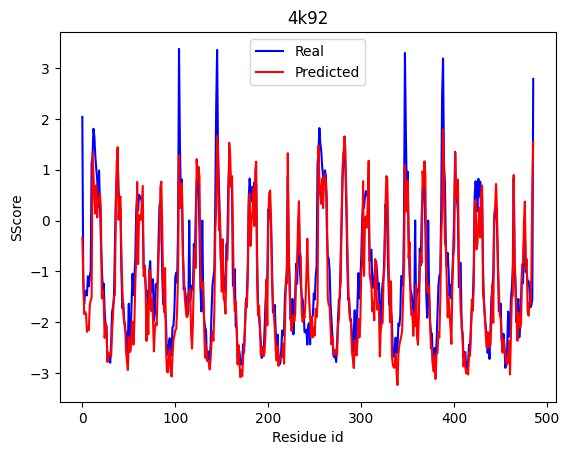

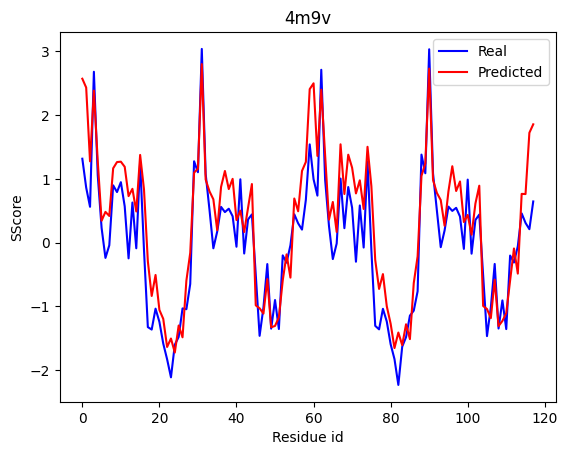

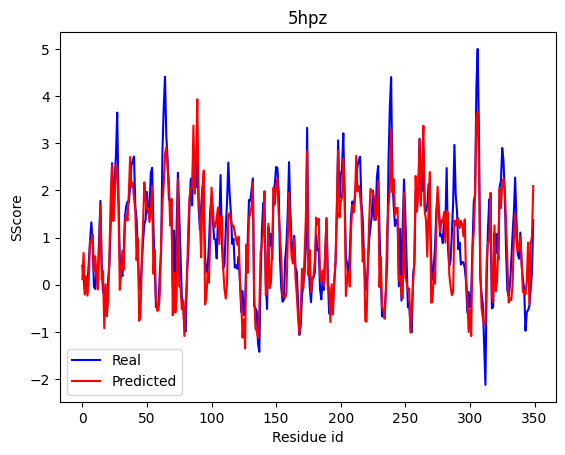

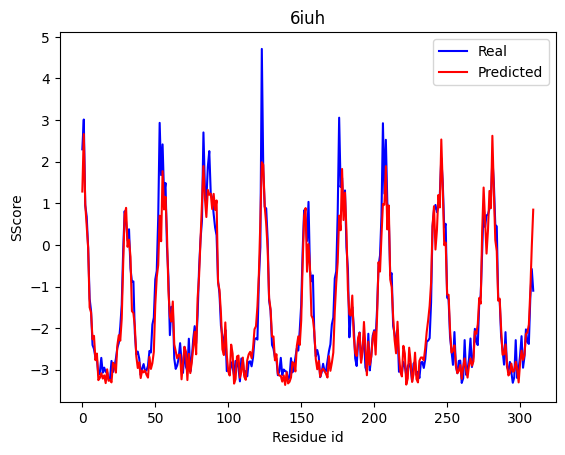

In [9]:
## Compare predicted and real sscores (if applicable)
import matplotlib.pyplot as plt

for pdb in real_sscore.keys():
    plt.plot(real_sscore[pdb], color='blue', label='Real')
    plt.plot(pred_sscore[pdb], color='red', label='Predicted')
    plt.xlabel('Residue id')
    plt.ylabel('SScore')
    plt.legend()
    plt.title(pdb)
    plt.show()
    plt.close()


In [29]:
# ## Save predicted sscores
# import pickle

# output_path = 'test_output.pickle'

# with open(output_path, 'wb') as f:
#     pickle.dump(pred_sscore, f)